In [9]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

In [10]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, help="name base of vtk files - they are usually in a vtk-subdirectory!", default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--resolution", type=int, default=40)
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=200)
parser.add_argument("--tmax", type=int, default=10)
parser.add_argument("--Re", type=int, default=800)
parser.add_argument("--collision_operator", type=str, default="BGK")
parser.add_argument("--Precision", type=str, default="Double")
parser.add_argument("--Mach", type=float, default=0.05)
args, unknown = parser.parse_known_args()
args = vars(args)
print("ICH FUNKTIONIERE MIT PULLEN")
Re=args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
res = args["resolution"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
Precision= args["Precision"]
collision_operator = args["collision_operator"]
Mach = args["Mach"]
print(collision_operator)
print(torch.version.cuda)

ICH FUNKTIONIERE MIT PULLEN
BGK
12.1
ICH FUNKTIONIERE MIT PULLEN
BGK
12.1


In [11]:
print(Precision)
lattice = lt.Lattice(lt.D3Q27, device = "cuda", dtype=torch.float32 if Precision == "Single" else torch.float64)
flow = lt.TaylorGreenVortex3D(resolution=res, reynolds_number=Re, mach_number=Mach, lattice=lattice)
print(flow.units.convert_time_to_lu(tmax))
tensor=torch.tensor(1)
print(tensor.dtype)
# Konstruktion des Funktionsnamens
function_name = f"{collision_operator}Collision"

# Überprüfung, ob die Funktion existiert, und deren Aufruf
#if hasattr(lt, function_name):
#    collision = getattr(lt, function_name)(lattice, tau=flow.units.relaxation_parameter_lu)
#    print(collision_operator)
#else:
#    print(":(((")
#    raise ValueError(f"Collision type {collision_operator} is not supported.")
if collision_operator == "BGK":
    collision=lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
elif collision_operator == "KBC":
    collision=lt.KBCCollision3D(lattice, tau=flow.units.relaxation_parameter_lu)
#collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
#collision=collision_type(lattice, tau=flow.units.relaxation_parameter_lu)
print(flow.units.relaxation_parameter_lu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)


Double
2205.315581687168
torch.int64
0.5006891611192772
torch.float64
torch.float64
Double
2205.315581687168
torch.int64
0.5006891611192772
torch.float64
torch.float64


In [12]:
interval_vtk=int((flow.units.convert_time_to_lu(tmax))/20)
interval_out=int((flow.units.convert_time_to_lu(tmax))/200)
Energy = lt.IncompressibleKineticEnergy(lattice, flow)
Dissipation_TGV=lt.Dissipation_sij(lattice, flow)
Enstrophy=lt.Enstrophy(lattice, flow)
Energyspectrum= lt.EnergySpectrum(lattice, flow)


reporter = lt.ObservableReporter(Energy, interval=interval_out, out=None)
reporter2 = lt.ObservableReporter(Dissipation_TGV,interval = interval_out, out=None)
reporter3= lt.ObservableReporter(Enstrophy, interval=interval_out, out=None)
reporter4=lt.ObservableReporter(Energyspectrum, interval=interval_out, out=None)
simulation.reporters.append(reporter)
simulation.reporters.append(reporter2)
simulation.reporters.append(reporter3)
simulation.reporters.append(reporter4)
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps = int(flow.units.convert_time_to_lu(tmax))
print(steps)
#simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps     time     IncompressibleKineticEnergy
steps     time     Dissipation_sij
steps     time     Enstrophy
steps     time     EnergySpectrum
2205


/home/ben/anaconda3/envs/lettuce/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


steps     time     IncompressibleKineticEnergy
steps     time     Dissipation_sij
steps     time     Enstrophy
steps     time     EnergySpectrum
2205


In [13]:
simulation.initialize_f_neq()
steps = int(flow.units.convert_time_to_lu(tmax))
mlups = simulation.step(num_steps=steps)
print("Performance in MLUPS:", mlups)
print(steps)

torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.

In [14]:
energy = np.array(simulation.reporters[0].out)
dissipation = np.array(simulation.reporters[1].out)
enstrophy=np.array(simulation.reporters[2].out)

dEdt=np.zeros(len(energy[:,2]))
dt=energy[1,1]-energy[0,1]
nmax=len(energy[:,2])
for i in range(len(energy[:,2])):
    if i == 0:
        dEdt[i] = (energy[1,2] - energy[0,2]) / dt
    elif i == 1:
        dEdt[i] = (energy[2,2] - energy[0,2]) / 2/dt
    elif i == 2:
        dEdt[i] = (1/12*energy[0,2] - 2/3*energy[1,2] + 2/3*energy[3,2] - 1/12*energy[4,2]) / dt
    elif i >= (nmax-3):
        if i == (nmax-3):
            dEdt[i] = (1/12*energy[nmax-5,2] - 2/3*energy[nmax-4,2] + 2/3*energy[nmax-2,2] - 1/12*energy[nmax-1,2]) / dt
        elif i == (nmax-2):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-3,2]) /2/ dt
        elif i == (nmax-1):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-2,2]) /dt
    elif i < (nmax-3):
        dEdt[i] = (-1/60*energy[i-3,2] + 3/20*energy[i-2,2] - 3/4*energy[i-1,2] + 3/4*energy[i+1,2] - 3/20*energy[i+2,2] + 1/60*energy[i+3,2]) / dt
dissipationEkin=np.array([energy[:,1],-dEdt/(np.pi*2)**3])
dissipationEns=np.array([enstrophy[:,1],flow.units.viscosity_pu/(np.pi*2)**3*enstrophy[:,2]])
dissipationSij=np.array([dissipation[:,1],dissipation[:,2]])

with open(csvdir + 'DissipationEkin.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEkin)
with open(csvdir + 'DissipationEnstrophy.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEns)
with open(csvdir + 'DissipationSij.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationSij)




[31.00627668 30.99457996 30.98286324 30.97098464 30.95928181 30.94717658
 30.93480511 30.92267142 30.91048888 30.89838358 30.88591999 30.87309757
 30.86000224 30.84739274 30.83473585 30.82180724 30.80841972 30.79457785
 30.78090944 30.76753826 30.75403404 30.7398237  30.72522062 30.71035274
 30.69579637 30.6813362  30.66633655 30.65058422 30.6345061  30.6184742
 30.60256706 30.58645202 30.56951719 30.55191223 30.53420426 30.51656791
 30.49879086 30.4804461  30.46124698 30.44155501 30.42188304 30.40213395
 30.38188575 30.36089596 30.3391296  30.3170677  30.29497069 30.27250825
 30.24931622 30.22529464 30.20072303 30.17587558 30.15083349 30.1251309
 30.09856596 30.07128379 30.04352218 30.01550583 29.98691719 29.9575927
 29.92727041 29.89644211 29.86506528 29.83326476 29.80065654 29.76710308
 29.73271319 29.69766454 29.66210261 29.62563844 29.58831987 29.549789
 29.51052925 29.47038847 29.42945846 29.38735884 29.3440556  29.29957043
 29.25398843 29.20740566 29.15941741 29.11004741 29.0590

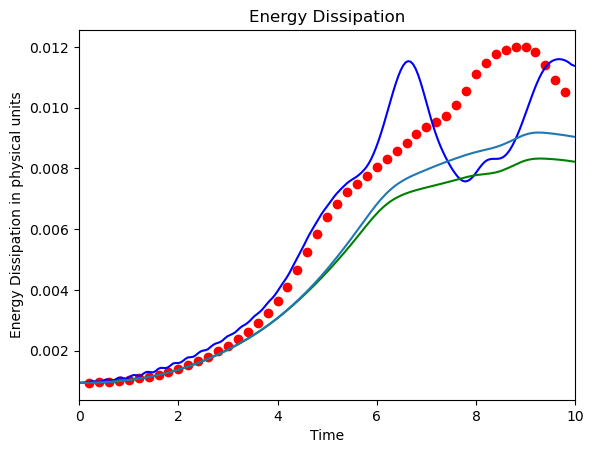

[31.00627668 30.99457996 30.98286324 30.97098464 30.95928181 30.94717658
 30.93480511 30.92267142 30.91048888 30.89838358 30.88591999 30.87309757
 30.86000224 30.84739274 30.83473585 30.82180724 30.80841972 30.79457785
 30.78090944 30.76753826 30.75403404 30.7398237  30.72522062 30.71035274
 30.69579637 30.6813362  30.66633655 30.65058422 30.6345061  30.6184742
 30.60256706 30.58645202 30.56951719 30.55191223 30.53420426 30.51656791
 30.49879086 30.4804461  30.46124698 30.44155501 30.42188304 30.40213395
 30.38188575 30.36089596 30.3391296  30.3170677  30.29497069 30.27250825
 30.24931622 30.22529464 30.20072303 30.17587558 30.15083349 30.1251309
 30.09856596 30.07128379 30.04352218 30.01550583 29.98691719 29.9575927
 29.92727041 29.89644211 29.86506528 29.83326476 29.80065654 29.76710308
 29.73271319 29.69766454 29.66210261 29.62563844 29.58831987 29.549789
 29.51052925 29.47038847 29.42945846 29.38735884 29.3440556  29.29957043
 29.25398843 29.20740566 29.15941741 29.11004741 29.0590

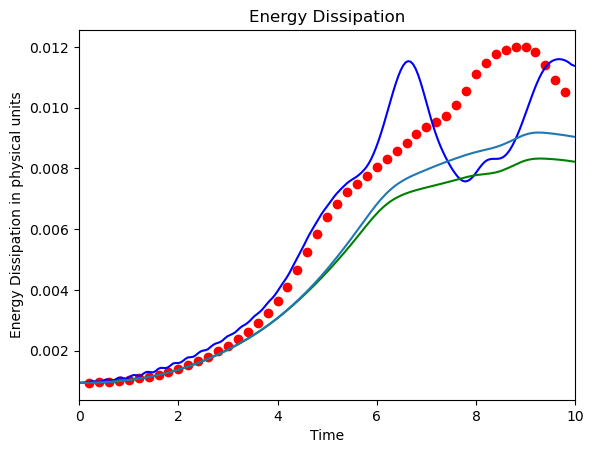

In [15]:
csv_file_path = '/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re800.csv'

# Daten aus der CSV-Datei lesen
csv_data = []
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        csv_data.append(row)

csv_data = np.array(csv_data, dtype=float)
print(energy[:,2])
plt.plot(dissipationEkin[0,:],dissipationEkin[1,:],color = 'blue')
plt.plot(dissipationEns[0,:],dissipationEns[1,:], color = 'green')
plt.xlim(0,10)
plt.plot(dissipationSij[0,:],dissipationSij[1,:])
plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='CSV Data')
plt.title('Energy Dissipation')
#plt.plot(energy[:,1],energy[:,2])
plt.xlabel('Time')
plt.ylabel('Energy Dissipation in physical units')
plt.show()



MovieWriter imagemagick unavailable; using Pillow instead.


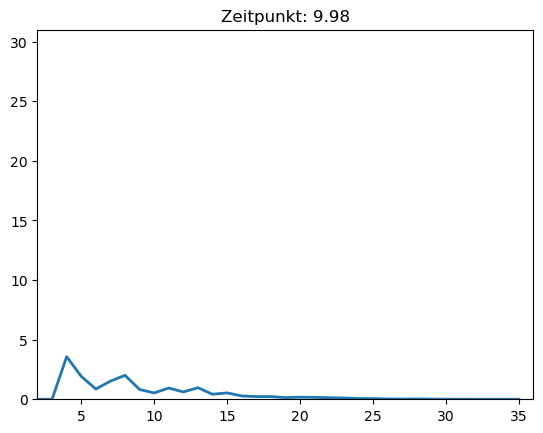

MovieWriter imagemagick unavailable; using Pillow instead.


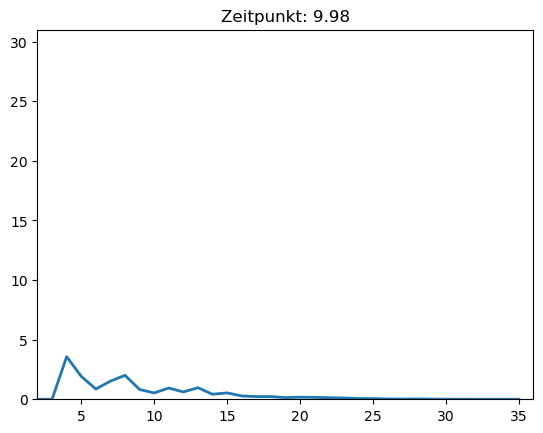

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

energy_spectrum= np.array(simulation.reporters[3].out)

# Initialisiere die Figur und die Achsen
fig, ax = plt.subplots()

# Plot initialisieren
line, = ax.plot([], [], lw=2)
ax.set_xlim(2, energy_spectrum.shape[1])  # Bereich der Wellenlängen (ab der dritten Spalte)
ax.set_ylim(np.min(energy_spectrum[:, 2:]), np.max(energy_spectrum[:, 2:]))  # Bereich der Energiespektren

# Initialisierungsfunktion: Zeichnet nur den Hintergrund des Plots
def init():
    line.set_data([], [])
    return (line,)

# Animationsfunktion: Diese wird in jedem Frame aufgerufen
def animate(i):
    x = np.arange(2, energy_spectrum.shape[1])  # Korrigierte Wellenlängen (x-Achse)
    y = energy_spectrum[i, 2:]  # Energiespektrum für die Zeit i
    line.set_data(x, y)
    ax.set_title(f'Zeitpunkt: {energy_spectrum[i, 1]:.2f}')  # Titel mit dem Zeitpunkt
    return (line,)

# Erstelle die Animation
ani = FuncAnimation(fig, animate, init_func=init, frames=energy_spectrum.shape[0], interval=100, blit=True)

# Speichern als GIF
ani.save('/home/ben/Schreibtisch/energy_spectrum_animation.gif', writer='imagemagick')
# Oder als MP4-Video speichern
# ani.save('energy_spectrum_animation.mp4', writer='ffmpeg')

plt.show()
